In [1]:
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import norm, ttest_ind
from datetime import datetime
import seaborn as sns

import ipywidgets as widgets
import os

from tqdm.notebook import tqdm

In [2]:
titlesize = 16
labelsize = 16
legendsize = 16
xticksize = 16
yticksize = xticksize

plt.rcParams['legend.markerscale'] = 1.5     # the relative size of legend markers vs. original
plt.rcParams['legend.handletextpad'] = 0.5
plt.rcParams['legend.labelspacing'] = 0.4    # the vertical space between the legend entries in fraction of fontsize
plt.rcParams['legend.borderpad'] = 0.5       # border whitespace in fontsize units
plt.rcParams['font.size'] = 12
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['axes.labelsize'] = labelsize
plt.rcParams['axes.titlesize'] = titlesize
plt.rcParams['figure.figsize'] = (10, 6)

plt.rc('xtick', labelsize=xticksize)
plt.rc('ytick', labelsize=yticksize)
plt.rc('legend', fontsize=legendsize)

# 1. Размер выборки (sample size)

Напишем функцию для оценки размера выборки. Проверим на искусственных данных, что она работает корректно.

$$n > \dfrac{\left[ \Phi^{-1} \Bigl( 1-\dfrac{\alpha}{2} \Bigr) + \Phi^{-1} \Bigl( 1-\beta \Bigr) \right]^2 (\sigma_X^2 + \sigma_Y^2)}{\varepsilon^2}$$

Реализуем эту формулу для случая равных дисперсий:

In [3]:
def get_sample_size_abs(epsilon, std, alpha=0.05, beta=0.2):
    t_alpha = norm.ppf(1 - alpha / 2, loc=0, scale=1)
    t_beta = norm.ppf(1 - beta, loc=0, scale=1)
    z_scores_sum_squared = (t_alpha + t_beta) ** 2
    sample_size = int(
        np.ceil(
            z_scores_sum_squared * (2 * std ** 2) / (epsilon ** 2)
        )
    )
    return sample_size

def get_sample_size_arb(mu, std, eff=1.01, alpha=0.05, beta=0.2):
    epsilon = (eff - 1) * mu

    return get_sample_size_abs(epsilon, std=std, alpha=alpha, beta=beta)

# 2. MDE

Напишем функцию для оценки размера выборки:

$$\varepsilon > \frac{\left[ \Phi^{-1} \left( 1-\dfrac{\alpha}{2} \right) + \Phi^{-1} \left( 1-\beta \right) \right] \sqrt{ \sigma_X^2 + \sigma_Y^2 }}{\sqrt{n}}$$

Реализуем эту формулу для случая равных дисперсий:

In [4]:
def get_minimal_determinable_effect(std, sample_size, alpha=0.05, beta=0.2):
    t_alpha = norm.ppf(1 - alpha / 2, loc=0, scale=1)
    t_beta = norm.ppf(1 - beta, loc=0, scale=1)
    disp_sum_sqrt = (2 * (std ** 2)) ** 0.5
    mde = (t_alpha + t_beta) * disp_sum_sqrt / np.sqrt(sample_size)
    return mde

## 3. Цена ошибки
$\mu$ и $std$ мы можем оценить по историческим данным, $\alpha$ и $\beta$ — определяем сами допустимые для нас ошибки. Как определить ожидаемый эффект, к чему могут привести завышенные ожидания?

Смоделируем ситуации, когда ожидаемый и реальный эффект не совпадают, посмотрим, как будет меняться ошибка второго рода.

In [5]:
def check_ttest(a, b, alpha=0.05):
    """Тест Стьюдента. Возвращает 1, если отличия значимы."""
    _, pvalue = ttest_ind(a, b)
    return int(pvalue < alpha)

sample_size = 252



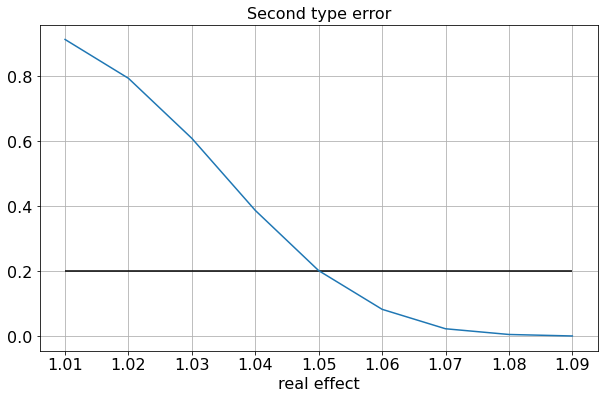

In [6]:
mu = 10
std = 2
eff = 1.05
alpha = 0.05
beta = 0.2

real_effs = np.linspace(1.01, 1.09, 9)


sample_size = get_sample_size_arb(mu, std, eff, alpha, beta)
print(f'sample_size = {sample_size}\n')

second_errors = []
for real_eff in real_effs:
    result_ab = []
    for _ in range(10000):
        a = np.random.normal(mu, std, sample_size)
        b = np.random.normal(mu * real_eff, std, sample_size)
        result_ab.append(check_ttest(a, b))
    second_errors.append(1 - np.mean(result_ab))



plt.plot(real_effs, second_errors)
plt.title('Second type error')
plt.hlines(0.2, 1.01, 1.09, label='beta')
plt.xlabel('real effect')
plt.grid()
plt.show()

Получаем, что если мы ошиблись в эффекте на 1%, думали будет 5%, а оказалось 4%, то это увеличивает ошибку второго рода в два раза, с 20% до 40%.

Если есть возможность, лучше собирать данные с запасом.

# 5. A/A тесты. Распределение $p-value$

Давайте напишем вспомогательную функцию. Она будет отрисовывать эмпирическое распределение $p-value$. 

Ниже мы обсудим, какие условия должны быть выполнены, чтобы считалось, что наш тест корректен.

In [7]:
def plot_pvalue_ecdf(pvalues, title=None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    if title:
        plt.suptitle(title)

    sns.histplot(pvalues, ax=ax1, bins=20, stat='density')
    ax1.plot([0,1],[1,1], 'k--')
    ax1.set(xlabel='p-value', ylabel='Density')

    sns.ecdfplot(pvalues, ax=ax2)
    ax2.plot([0,1],[0,1], 'k--')
    ax2.set(xlabel='p-value', ylabel='Probability')
    ax2.grid()

### Контроль вероятности ошибки I рода

Существует теорема, которая гласит, что $p-value$ распределено равномерно от 0 до 1 при условии, что нулевая гипотеза $H_0$ верна. То есть:
$$p-value | H_0 \sim U[0, 1]$$
$$F_{p-value | H_0}(x) = \mathbb{P}(p\_value < x | H_0) = x$$

Равномерность распределения p-value при верности нулевой гипотезы — это необходимое условие корректной работы стат критерия. Мы научились опрелять, контролируется ли вероятность ошибки 1-го рода для заданного дизайна. Чтобы проверить равномерность распределения нужно многократно просимулировать эксперименты без наличия эффекта. Мы должны убедиться, что если мы многократно запускаем А/А тесты, то $p-value$ должно иметь равномерное распределение. 

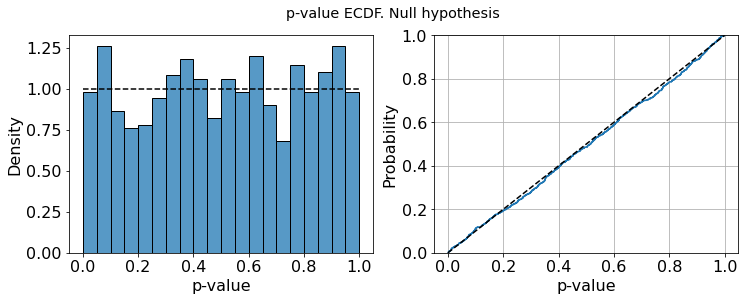

In [8]:
mean = 0
std = 1
sample_size = 100

p_values = []
for _ in range(1000):
    a = np.random.normal(mean, std, sample_size)
    b = np.random.normal(mean, std, sample_size)
    _, p_val = ttest_ind(a, b)
#     p_val = np.random.uniform(0, 1)
    p_values.append(p_val)

plot_pvalue_ecdf(p_values, 'p-value ECDF. Null hypothesis')

Интуитивно это свойство тоже ясно. При отсутствии эффекта мы должны контролировать вероятность ошибки 1-го рода, то есть
* на уровне значимости 0.05 мы должны ошибаться в среднем в 5 случаях из 100;
* на уровне значимости 0.1 мы должны ошибаться в среднем в 10 случаях из 100;
* на уровне значимости 0.2 мы должны ошибаться в среднем в 20 случаях из 100.

Это и есть определение равномерной случайной величины $U[0, 1]$.
$$F_{U[0, 1]}(x) = x$$


### Контроль вероятности ошибки 2-го рода

Мы научились проверять, контролируется ли вероятность ошибки 1-го рода. Например, если бы статистический тест возвращал случайное число от 0 до 1, то он бы отлично контролировал вероятность ошибки 1-го рода, но смысла в таком тесте нет. Мы переходим к **мощности** теста. 

Что означает, что мощность теста при заданном MDE равна 0.8? Это означает, что если на самом деле эффект, равный MDE, присутствует, то мы должны в среднем обнаруживать его в 80 случаях из 100. То есть если верна альтернативная гипотеза, то функция распределения $p-value$ должна быть выпуклой и равняться мощности теста на заданном уровне значимости.

То есть в нашем примере:
$$F_{p-value | H_1}(\alpha) = \mathbb{P}(p-value < \alpha | H_1) = 1 - \beta$$

Чтобы проверить, обладает ли тест заданной мощностью, нужно многократно просимулировать эксперименты без наличия эффекта, к одной из групп добавляя эффект, равный MDE. В этом случае распределие $p-value$ должно быть выпуклым с заданной мощностью. 

In [9]:
sample_size

100

mde is 0.396


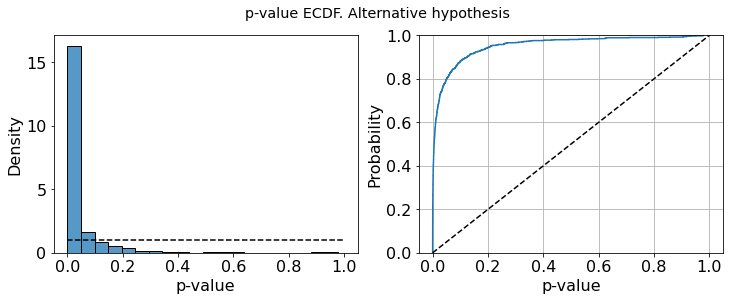

In [10]:
alpha = 0.05
beta = 0.2
mde = get_minimal_determinable_effect(std, sample_size, alpha, beta)
print(f'mde is {np.round(mde, 3)}')

p_values = []
for _ in range(1000):
    a = np.random.normal(mean, std, sample_size)
    b = np.random.normal(mean, std, sample_size) + mde
    _, p_val = ttest_ind(a, b)
    p_values.append(p_val)

plot_pvalue_ecdf(p_values, 'p-value ECDF. Alternative hypothesis')

# 6. A/A тесты для зависимых значений

Приведем простой пример, когда нулевая гипотеза верна, то есть на самом деле $\mathbb{E}X = \mathbb{E}Y$, но $p-value$ распределено не равномерно. То есть условия применимости t-test не выполнены. 

Для этого, как и в предыдущем примере, многократно сгенерируем две выборки из одного распределения, но продублируем их значения несколько раз.

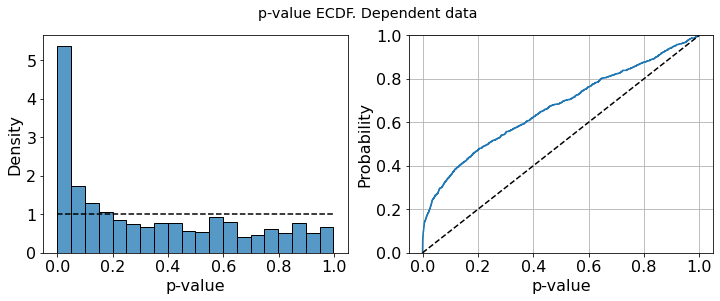

In [11]:
replication_factor = 3
p_values = []
for _ in range(1000):
    a_ = np.random.normal(mean, std, sample_size)
    b_ = np.random.normal(mean, std, sample_size)
    a = np.concatenate([a_] * replication_factor)
    b = np.concatenate([b_] * replication_factor)

    _, p_val = ttest_ind(a, b)
    p_values.append(p_val)

plot_pvalue_ecdf(p_values, 'p-value ECDF. Dependent data')

In [12]:
(np.array(p_values) < 0.05).mean()

0.268

Мы видим, что в данном случае вероятность ошибки 1-го рода не контролируется. Это означает, что если бы мы слепо применили t-test, взяли то, что возвращает данная функция (фактически, это уже не $p-value$, а просто какое-то число от 0 до 1), а затем сравнили с уровнем значимости, то при уровне значимости 0.05 вероятность ошибки 1-го рода равнялась бы 0.28 вместо 0.05, то есть в 5.5 раз больше!

# Данные пиццерии

Предположим, мы хотим спроектировать дизайн эксперимента для целевой метрики средний чек:

In [13]:
URL_BASE = 'https://raw.githubusercontent.com/ab-courses/simulator-ab-datasets/main/2022-04-01/'

def read_database(file_name):
    return pd.read_csv(os.path.join(URL_BASE, file_name))

web_logs = read_database('2022-04-01T12_df_web_logs.csv')

In [14]:
sales = read_database('2022-04-01T12_df_sales.csv')
sales['date'] = pd.to_datetime(sales['date'])
sales.head(3)

,sale_id,date,count_pizza,count_drink,price,user_id
0,1000001,2022-02-04 10:00:24,1,0,720,1c1543
1,1000002,2022-02-04 10:02:28,1,1,930,a9a6e8
2,1000003,2022-02-04 10:02:35,3,1,1980,23420a


sales — таблица с информаций о покупках, одна строка — один заказ. 

1. sale_id — идентификатор покупки;
2. date — дата покупки;
3. count_pizza — количество пицц в заказе;
4. count_drink — количество напитков в заказе;
5. price — стоимость заказа;
6. user_id — идентификатор пользователя.

2022-02-04 10:00:24
2022-04-01 11:59:51
(203847, 6)


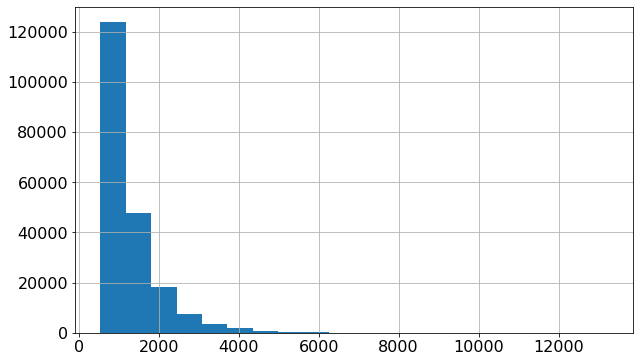

In [15]:
print(sales['date'].min())
print(sales['date'].max())
print(sales.shape)
sales['price'].hist(bins=20);

Предположим, что мы хотим проводить тест в течение 4х недель.

Для этого на историческом промежутке выберем интервал длиной в одну неделю и проведем все расчеты для данного промежутка времени. Отметим, что сегодня 1 апреля, поэтому мы взяли неделю непосредственно перед запуском эксперимента. Данный подход служит неплохой эвристикой.

In [16]:
sales_hist = sales[
    (sales['date'] >= datetime(2022, 3, 1))
    & (sales['date'] < datetime(2022, 3, 29))
]
sales_hist.shape

(101951, 6)

Чтобы проверить корректность дизайна эксперимента, мы должны многократно просимулировать этот эксперимент на исторических данных. Сначала проверим, контролируется ли вероятность ошибки 1-го рода. Для этого объектами в нашей выборке будут **чеки**. То есть мы делим всех людей на 2 группы, собираем все чеки назвисимо и проводим t-test.

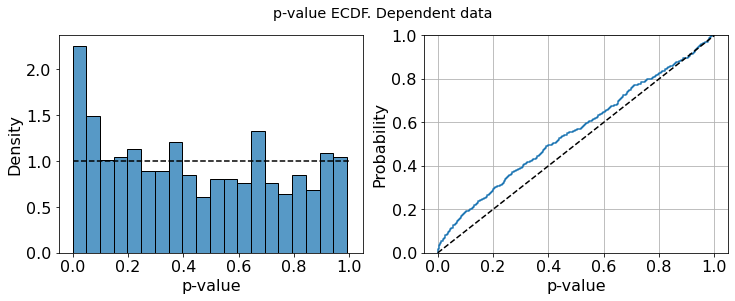

In [17]:
# sales_hist = sales

p_values = []
users = sales_hist['user_id'].unique()
for _ in range(500):
    np.random.shuffle(users)
    group_a, group_b = users[:len(users) // 2], users[len(users) // 2:]
    sales_a = sales_hist[sales_hist['user_id'].isin(group_a)]['price']
    sales_b = sales_hist[sales_hist['user_id'].isin(group_b)]['price']
    _, p_val = ttest_ind(sales_a, sales_b)
    p_values.append(p_val)
plot_pvalue_ecdf(p_values, 'p-value ECDF. Dependent data')

In [18]:
(np.array(p_values) < 0.05).mean()

0.112

Видно, что $p-value$ распределено не равномерно. То есть если бы мы бездумно применили t-test к данной выборке, то на уровне значимости 0.05 ошибались бы с вероятностью более 0.1. Это значит, что мы бы в среднем получали в 2 раза больше ложноположительных результата, чем допускает дизайн эксперимента. 

Такое поведения связано с тем, что выборка не удовлетворяет условиям регулярности t-test, в частности, наблюдения не независимы, так как один человек в течение эксперимента может сделать несколько покупок.

Как работать с метриками такого типа мы обсудим на лекции, посвященной метрикам отношения, а сейчас просто перейдем к другой метрике. Давайте рассмотрим метрику **средний чек на пользователя**. То есть мы сначала для каждого человека посчитаем его средний чек, а затем сравним два набора таких значений. Таким образом, наши данные уже будут статистически независимы, так как от каждого пользователя мы получим одно значение, а пользователи между собой независимы. После этого повторим процедуру, описанную выше.

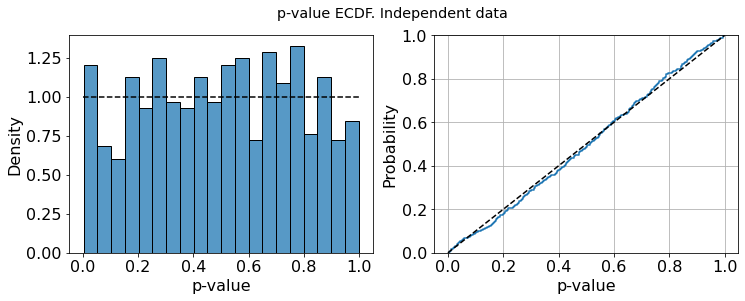

In [19]:
p_values = []
grouped_sales = sales_hist.groupby('user_id')[['price']].mean().reset_index()
users = sales_hist['user_id'].unique()
for _ in range(500):
    np.random.shuffle(users)
    group_a, group_b = users[:len(users) // 2], users[len(users) // 2:]
    sales_a = grouped_sales[grouped_sales['user_id'].isin(group_a)]['price']
    sales_b = grouped_sales[grouped_sales['user_id'].isin(group_b)]['price']
    _, p_val = ttest_ind(sales_a, sales_b)
    p_values.append(p_val)
plot_pvalue_ecdf(p_values, 'p-value ECDF. Independent data')

Видно, что вероятность ошибки 1-го рода контролируется. Но обладает ли наш тест достаточной мощностью?

Давайте проверим это. Для этого посчитаем MDE и будем к одной из групп прибавлять случайный эффект, равный MDE.

In [20]:
mean = grouped_sales['price'].mean()
std = grouped_sales['price'].std()
sample_size = grouped_sales.shape[0] // 2
alpha = 0.05
beta = 0.2

mde = get_minimal_determinable_effect(std, sample_size, alpha, beta)
print(f'mde is {np.round(mde, 3)}')

mde is 15.866


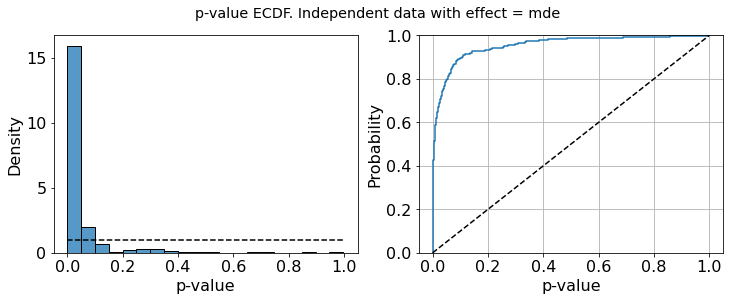

In [21]:
p_values = []
grouped_sales = sales_hist.groupby('user_id')[['price']].mean().reset_index()
users = sales_hist['user_id'].unique()
for _ in range(500):
    np.random.shuffle(users)
    group_a, group_b = users[:len(users) // 2], users[len(users) // 2:]
    sales_a = grouped_sales[grouped_sales['user_id'].isin(group_a)]['price']
    sales_b = grouped_sales[grouped_sales['user_id'].isin(group_b)]['price']
    sales_b += np.random.normal(mde, std // 10, sales_b.shape)
    _, p_val = ttest_ind(sales_a, sales_b)
    p_values.append(p_val)
plot_pvalue_ecdf(p_values, 'p-value ECDF. Independent data with effect = mde')

На уровне значимости 0.05 мы отлавливаем эффект в среднем в 80-ти случаях из 100, то есть тест обладает заданной мощностью и дизайн полностью корректен. 

То есть если мы будем проводить тест на всех пользователях в течение 4-х недель на уровне значимости 0.05, то вероятность ошибки 1-го рода в действительности равняется 0.05. Более того, мы обнаружим эффект равный $MDE=15.8$ в среднем в 80-ти случаях из 100, если он на самом деле присутствует, что мы и закладывали в дизайне эксперимента.